# Building Model LSTM
### By **Néstor Suat** in 2020

**Descripción:** Generando un modelo ML para la tarea de NER en tweets de accidentes para las etiquetas `loc` y `time` usando el estandar BIO.

**Input:**
* TSV con dataset etiquetado con BIO

**Output:**
* Model

**Tomado de**: https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/
***

In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

#plt.style.use("ggplot")

In [2]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            #s = self.grouped["Sentence: {}".format(self.n_sent)]
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

### Importando dataset anotado

In [3]:
file = 'ner-crf-training-data.tsv'
dir_ = "../../../data/v1/NER/"
data = pd.read_csv(dir_+file, delimiter = "\t", quoting = 3, names=['Sentence #','Word','POS','Tag'])
#dataset[:50]

In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

456

In [5]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

5

In [6]:
getter = SentenceGetter(data)

In [7]:
sent = getter.get_next()
print(sent)

[('sectormovilidad', 'NOUN', 'O'), ('giro', 'NOUN', 'O'), ('paa', 'NOUN', 'O'), ('tomar', 'VERB', 'O'), ('la', 'DET', 'O'), ('calle', 'NOUN', 'B-loc'), ('80', 'NUM', 'I-loc'), ('al', 'ADP', 'O'), ('occidente', 'NOUN', 'O'), ('en', 'ADP', 'O'), ('av', 'NOUN', 'B-loc'), ('Boyaca', 'PROPN', 'I-loc'), ('bloqueado', 'ADJ', 'O'), ('por', 'ADP', 'O'), ('accidente', 'NOUN', 'O'), ('simple', 'ADJ', 'O'), (',', 'PUNCT', 'O'), ('paso', 'NOUN', 'O'), ('bloqueado', 'ADJ', 'O')]


In [8]:
sentences = getter.sentences

In [9]:
max_len = 55
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx['accidente']

213

In [11]:
tag2idx['B-loc']

2

## Tokenize and prepare the sentences

Construyendo vector de las oraciones

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [13]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

Agregando PAD para rellenar las oraciones cortas que cummplan con el tamaño de 55 tokens

In [14]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [15]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Train the model

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
#from keras_contrib.layers import CRF
import tensorflow_addons as tfa
import tensorflow as tf
from tf2crf import CRF

In [24]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=51, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(51, activation="relu"))(model)  # a dense layer as suggested by neuralNer
#crf = CRF(n_tags+1)  # CRF layer
crf = CRF(dtype='float32')
out = crf(model)  # output
#label_sequences = tf.convert_to_tensor(y, dtype=tf.float32)
# @tf.function
#out = tfa.text.crf_log_likelihood(model,label_sequences, max_len, transition_params=None)

In [26]:
model = Model(input, out)

In [49]:
model.compile(optimizer="rmsprop", loss=crf.loss, metrics=[crf.accuracy])

In [50]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 55)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 55, 20)            9140      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 55, 102)           29376     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 55, 51)            5253      
_________________________________________________________________
crf_2 (CRF)                  (None, 55)                2601      
Total params: 46,370
Trainable params: 46,370
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Epoch 1/5
2/2 [==============================] - 0s 63ms/step - loss: 7.0007 - accuracy: 0.8012 - val_loss: 24.5351 - val_accuracy: 0.7570
Epoch 2/5
2/2 [==============================] - 0s 47ms/step - loss: 7.0121 - accuracy: 0.7961 - val_loss: 24.5083 - val_accuracy: 0.7570
Epoch 3/5
2/2 [==============================] - 0s 46ms/step - loss: 7.0616 - accuracy: 0.8012 - val_loss: 24.4829 - val_accuracy: 0.7570
Epoch 4/5
2/2 [==============================] - 0s 48ms/step - loss: 6.7207 - accuracy: 0.8022 - val_loss: 24.4611 - val_accuracy: 0.7570
Epoch 5/5
2/2 [==============================] - 0s 46ms/step - loss: 6.7066 - accuracy: 0.7951 - val_loss: 24.4412 - val_accuracy: 0.7570


In [58]:
hist = pd.DataFrame(history.history)

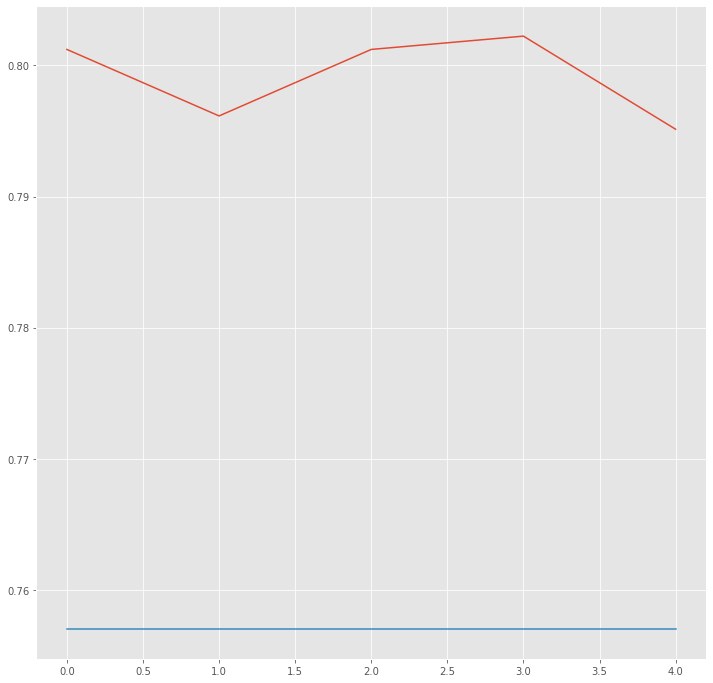

In [59]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()